# Proces minimalizace EMM

In [1]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

## minimalizace EMM v axialnim smeru

In [2]:
# data import
#import pandas as pd
import numpy as np

#data_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_delim.txt", sep="\t").values
#voltages_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_voltages.txt", sep="\t").values

data_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")
data_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")
data_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_delim.txt", delimiter="\t")[:,:2]
voltages_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_voltages.txt", delimiter="\t")

fotkor_bezcond=np.concatenate( (data_bezcond_p1 ,data_bezcond_p2, data_bezcond_p3) ,axis=1)
voltages_bezcond=np.concatenate( (voltages_bezcond_p1 ,voltages_bezcond_p2, voltages_bezcond_p3) ,axis=0)

# pomocne promene
fotkor_shape = np.shape(fotkor_bezcond)

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale = np.array( range(0,fotkor_shape[0]) ) *t_res

#---------- odecet pozadi
background_photocounts = 400 # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody
bg_ph_sum = background_photocounts * t_measure  # celkovy pocet fotonu pozadi za cas mereni
last_bin_ratio = fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin = bg_ph_sum/(fotkor_shape[0]-2 + last_bin_ratio)

fotkor_bezcond[:fotkor_shape[0]-2,:] = fotkor_bezcond[:fotkor_shape[0]-2,:] - bg_ph_per_bin 
fotkor_bezcond[fotkor_shape[0]-2,:] = fotkor_bezcond[fotkor_shape[0]-2,:] - bg_ph_per_bin * last_bin_ratio
# ------------------------------

In [3]:
# odhad periody triggeru
T_trig = ( fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9] )* t_res + t_scale[fotkor_shape[0]-2]

T_trig_sigma = t_res
# frekvence buzeni pasti

drive_freq = 1/T_trig
drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
Omega = 2*np.pi * drive_freq
Omega_sigma = 2*np.pi * drive_freq_sigma
drive_freq

30032035.976450287

In [4]:
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

Predpokladam, ze mam pouze dva body, pomoci nichz chci odhadnout minimum EMM.

In [6]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []
fot_phi = []

hist_sigma = 80  # empiricky odhadnuto --- muze se zmenit
W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)
#W_vec = 1/30**2 * np.ones(fotkor_shape[0]-2)
for i in range(fotkor_shape[1]):
    x0 = [fotkor_bezcond[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,i].max()
        -fotkor_bezcond[:fotkor_shape[0]-2,i].min() ), 1.5]
#     W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    #---- odhad nejistot parametru----
    jac = fit.jac
    C = np.linalg.inv( np.matmul( np.transpose(jac), np.matmul( np.diag(W_vec), jac ) ) )  # variancni-kovariancni matice
    resid_sq = fit.fun**2   # residua na druhou
    g_fit = resid_sq.sum() * 1/( len(W_vec) - 3)   # goodnes of fit
    #-------------------------------
    
    
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    
    #---- faze fot-kor signalu
    fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    
    
    #---- sigma delta s ku s
    S0 = fit.x[0]
    DeltaS = fit.x[1]
    Delta_S_S_ratio_sigma.append(np.sqrt( 1/S0**2 * C[0,0] + (DeltaS**2 / S0**4)*C[1,1] -2*(DeltaS/S0**3)*C[0,1]) )

In [10]:
nu_bezcond = (voltages_bezcond[:,0] - voltages_bezcond[:,1]) / (voltages_bezcond[:,0] + voltages_bezcond[:,1])

natituju namerene body primkou a na jejich zaklade urcim okoli minima

In [11]:
# fce vracejici residua

def MM_resid(x, deltaS_S, nu):
    return( deltaS_S - x[0] - x[1]*nu )

def MM_line(x, nu):
    return(x[0] + x[1]*nu)

In [48]:
# fit zavislosti deltaS/S (\nu)

x0 = [0.06, +0.1]

nu_minim = np.array([nu_bezcond[5],nu_bezcond[11]])
DeltaS_S_ratio_minim = np.array([DeltaS_S_ratio[5],DeltaS_S_ratio[11]])
fot_phi_minim = np.array( [fot_phi[5], fot_phi[11]] )

fit = least_squares(MM_resid,x0, args=(DeltaS_S_ratio_minim, nu_minim), 
                    ftol=1e-10, xtol=1e-10)
linfit_bezcond = fit.x


fit

 active_mask: array([0., 0.])
        cost: 1.8223156999283756e-20
         fun: array([-1.90909177e-10,  0.00000000e+00])
        grad: array([1.90909177e-10, 1.97492252e-11])
         jac: array([[-1.        , -0.10344828],
       [-1.        , -0.25      ]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 1.9090917735553603e-10
      status: 1
     success: True
           x: array([-0.21546664,  1.38224809])

In [35]:
# plot fitu deltaS/S(\nu) a bod s minimem EMM
nu_fit = np.linspace(nu_bezcond[5], nu_bezcond[11], 200)
DeltaS_S_fit_nu = MM_line(linfit_bezcond, nu_fit)

nu_MM_zero = - linfit_bezcond[0]/linfit_bezcond[1]  # expected MM zero
print("nu_EMM_zero = ", nu_MM_zero)

nu_EMM_zero =  0.15588130488604837


kolem tohoto bodu udelam interval umerny vzdalenosti mensiho deltaS_S od tohoto odhadu, napr. ctvrtinu a zaokrouhlim to na pulvolty

In [57]:
# naleznu interval ve kterem lezi minimum a urcim napeti, pro ktere bych mel merit v dalsi iteraci
min_inverv_leng = np.abs(min(nu_minim)- nu_MM_zero) * 0.25
min_interv = np.array( [nu_MM_zero - min_inverv_leng, nu_MM_zero + min_inverv_leng] )

# prepocet na napeti
U_avg = 500

U_5 = U_avg * (1 + min_interv)
U_6 = U_avg * (1 - min_interv)

print("prvni bod:")
print([U_5[0], U_6[0]])

print("druhy bod:")
print([U_5[1], U_6[1]])

prvni bod:
[571.3865238150267, 428.61347618497325]
druhy bod:
[584.4947810710216, 415.5052189289784]


In [58]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

In [59]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

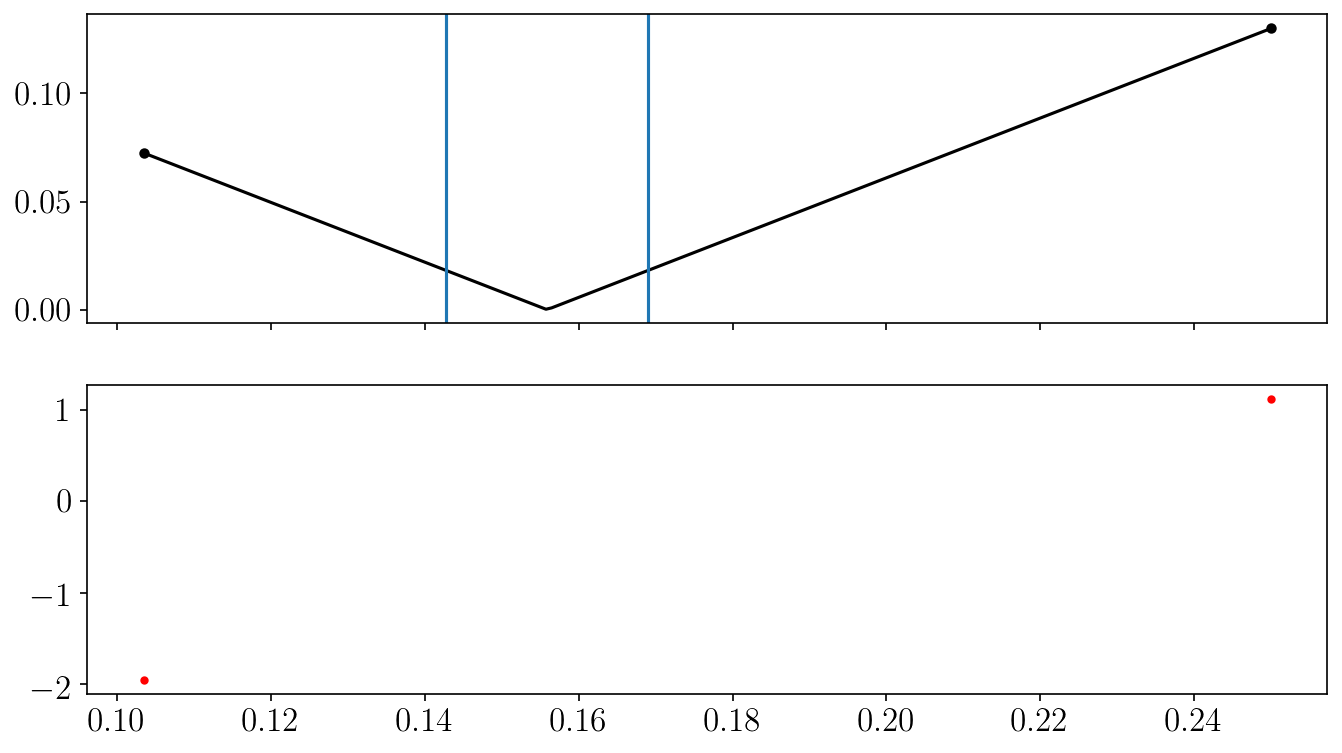

In [64]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

ax1.plot(nu_minim, np.abs(DeltaS_S_ratio_minim),
         '.', color='black', markersize=8)
ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu), label=r'1. krok ' + r'$\nu_{{\rm min}} \approx {:.4f}$'.format(nu_MM_zero), color='black')

ax2.plot(nu_minim, fot_phi_minim, '.', color='red')

# body v pristim kroku
ax1.axvline(min_interv[0])
ax1.axvline(min_interv[1])

nalezene minimum:

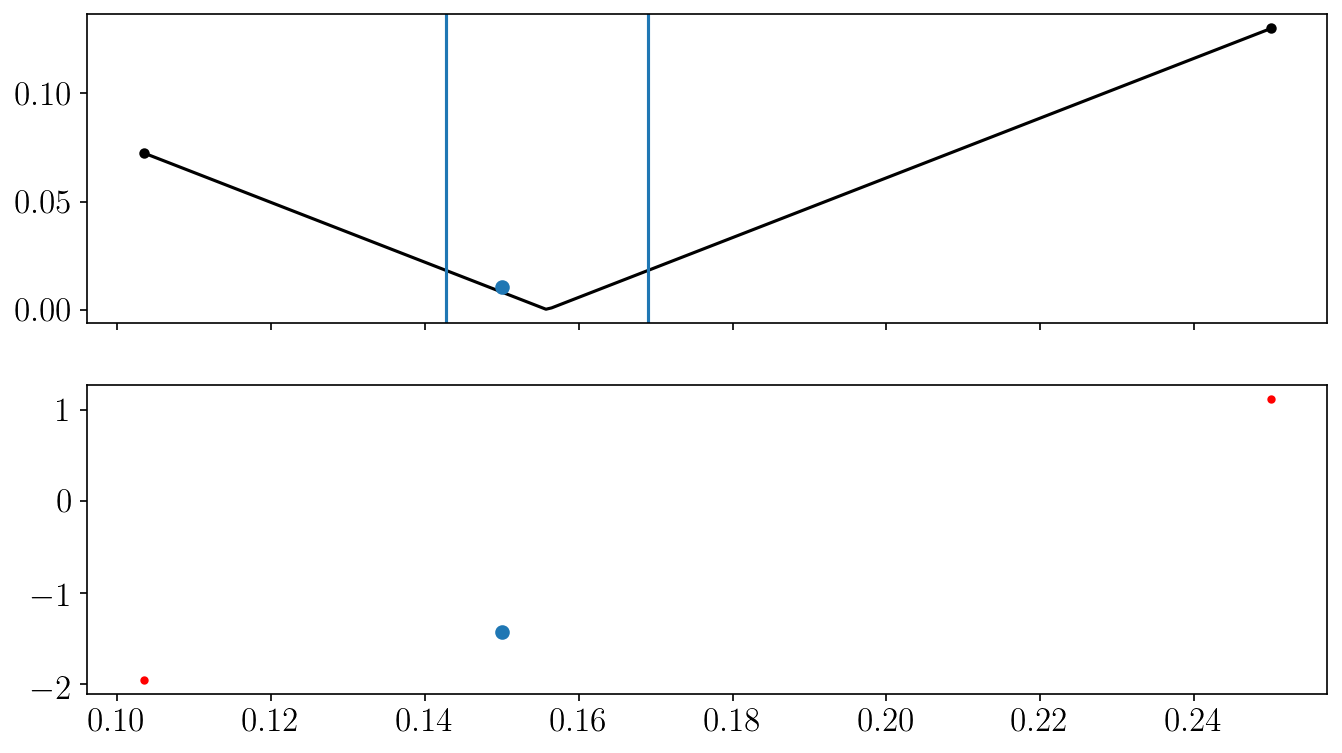

In [65]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

ax1.plot(nu_minim, np.abs(DeltaS_S_ratio_minim),
         '.', color='black', markersize=8)
ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu), label=r'1. krok ' + r'$\nu_{{\rm min}} \approx {:.4f}$'.format(nu_MM_zero), color='black')
ax1.plot(nu_bezcond[9], np.abs(DeltaS_S_ratio[9]),'o' )

ax2.plot(nu_minim, fot_phi_minim, '.', color='red')
ax2.plot(nu_bezcond[9], fot_phi[9], 'o')
# body v pristim kroku
ax1.axvline(min_interv[0])
ax1.axvline(min_interv[1])

In [66]:
DeltaS_S_min_z = np.abs( DeltaS_S_ratio[9] )
fot_phi_min_z = fot_phi[9]

In [68]:
print(np.abs( DeltaS_S_ratio[9] ) )
print(fot_phi[9])

0.010412358094199138
-1.4275066557281202
